## Library import

In [1]:
# Data processing

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

# Models

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import ward
from sklearn.mixture import GaussianMixture

In [2]:
from os import path
path_folder = 'dataset/'

## Data import 

In [3]:
# Paths to subjects data
# Female
path_subject_f01 = path.join(path_folder, 'alessandra_20220601_182359.csv')
path_subject_f02 = path.join(path_folder, 'aurora_20220601_180419.csv')
path_subject_f03 = path.join(path_folder, 'benedetta_20220601_184141.csv')
path_subject_f04 = path.join(path_folder, 'chloe_20220601_165046.csv')
path_subject_f05 = path.join(path_folder, 'giulia_20220601_171812.csv')
path_subject_f06 = path.join(path_folder, 'laura_20220601_174539.csv')
path_subject_f07 = path.join(path_folder, 'melissa_20220601_190124.csv')

# Male
path_subject_m01 = path.join(path_folder, 'axel_20220610_193124.csv')
path_subject_m02 = path.join(path_folder, 'fabio_20220601_193018.csv')
path_subject_m03 = path.join(path_folder, 'lilian_20220610_214447.csv')
path_subject_m04 = path.join(path_folder, 'massimo_20220601_194803.csv')

In [4]:
# Data reading
# Female
data_subject_f01 = pd.read_csv(path_subject_f01)
data_subject_f02 = pd.read_csv(path_subject_f02)
data_subject_f03 = pd.read_csv(path_subject_f03)
data_subject_f04 = pd.read_csv(path_subject_f04)
data_subject_f05 = pd.read_csv(path_subject_f05)
data_subject_f06 = pd.read_csv(path_subject_f06)
data_subject_f07 = pd.read_csv(path_subject_f07, on_bad_lines='skip') # --> Melissa's file is corrupted, missing positions from 2 to 4

# Male
data_subject_m01 = pd.read_csv(path_subject_m01, sep=';')
data_subject_m02 = pd.read_csv(path_subject_m02)  # --> Fabio's file is corrupted, sensor detached for positions 4 and 9
data_subject_m03 = pd.read_csv(path_subject_m03, sep=';')
data_subject_m04 = pd.read_csv(path_subject_m04)

data_subjects = [data_subject_f01, data_subject_f02, data_subject_f03, data_subject_f04, data_subject_f05, data_subject_f06, data_subject_f07, data_subject_m01, data_subject_m02, data_subject_m03, data_subject_m04]

## Data visualization and cleaning

This section aims to visualize the data collected, to look for potential outliers, and to prepare the final dataset that will be fed to the models.

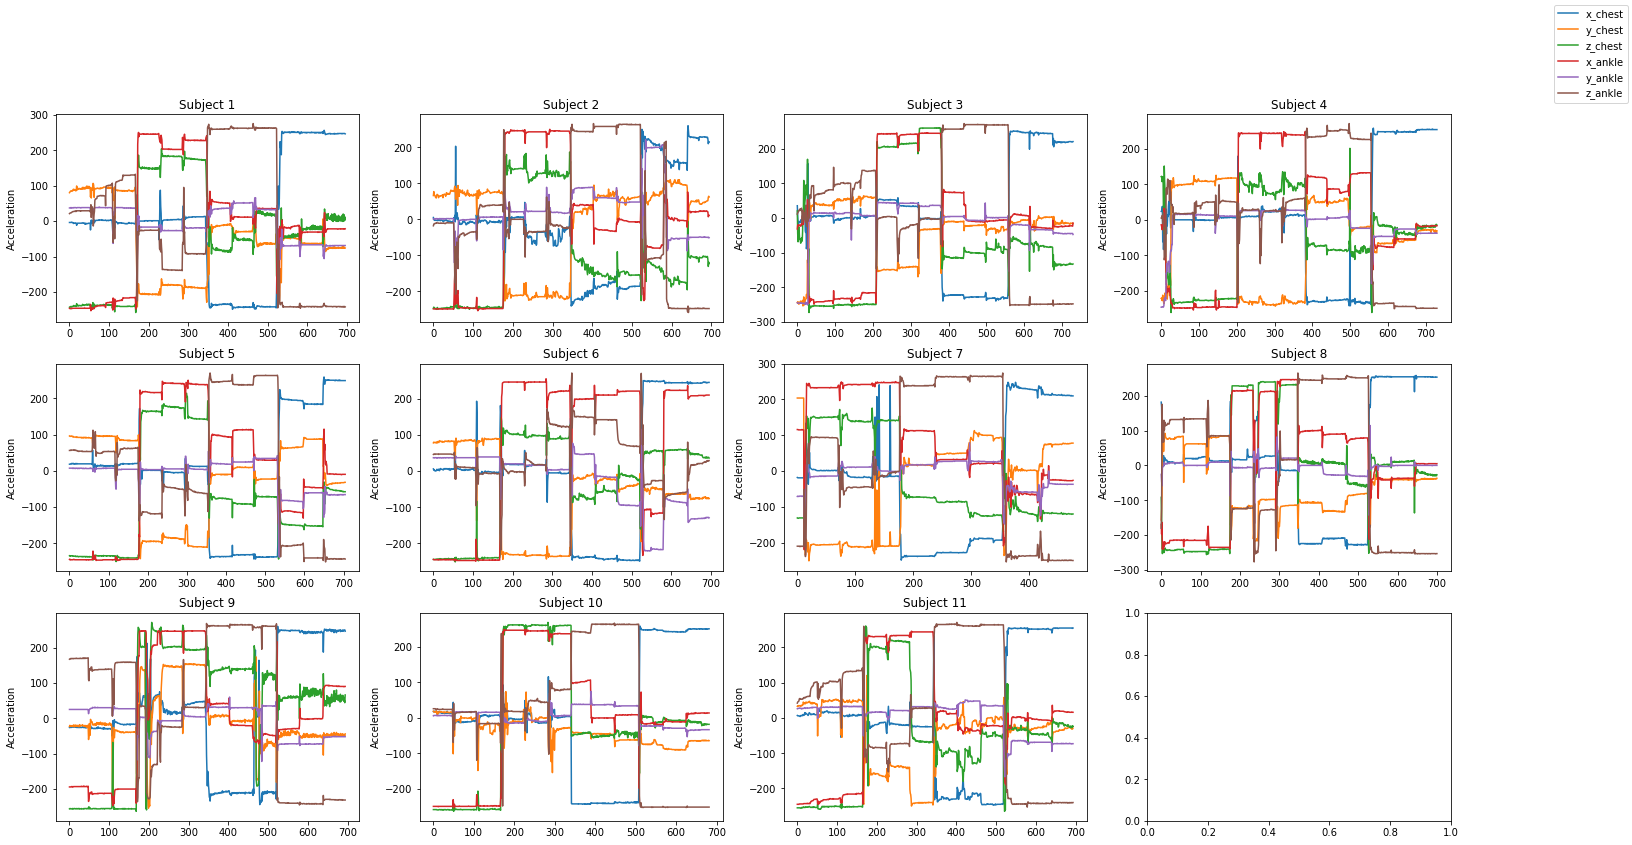

In [5]:
# Plot acceleration data for the 12 consecutive positions for each subject

fig, axs = plt.subplots(3, 4, figsize=(25,13))
axs = axs.flatten()
i = 0
subject_nb = 1

for data_subject in data_subjects:
  axs[i].plot(data_subject[['x_chest', 'y_chest', 'z_chest', 'x_ankle', 'y_ankle', 'z_ankle']])
  axs[i].set_title('Subject {}'.format(subject_nb))
  axs[i].set_ylabel('Acceleration')
  subject_nb += 1
  i += 1

fig.legend(['x_chest', 'y_chest', 'z_chest', 'x_ankle', 'y_ankle', 'z_ankle'])
plt.show()

From these graphs, it can be seen that for each subject, changing position, even though it was not recorded in the csv file, has resulted in some transient phases for the accelerometers to stabilize. \
Let's remove these phases by considering they span on at most 20 samples at the beginning of each position recording.

In [6]:
# Remove the transient parts in the data and create new datasets for each patient

subject_list = ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'm01', 'm02', 'm03', 'm04']
data_subjects_clean = []
position_indexes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for i in range(len(subject_list)):

  # Clean the subject's data by removing the transient portions
  subject_data = pd.DataFrame(data_subjects[i])
  subject_data_clean = pd.DataFrame()

  for pos_idx in position_indexes:
    position_data = subject_data.loc[subject_data['position']==pos_idx]

    if position_data.shape[0] != 0:

      # Remove the 20 first rows for each position if more than 20 samples are present
      if position_data.shape[0] > 20:
        position_data_cleaned = position_data.iloc[20:,:]
        
      # If there is no 20 records for that subject and position, keep the raw data 
      else:
        position_data_cleaned = position_data

    subject_data_clean = pd.concat([subject_data_clean, position_data_cleaned], axis=0)   

  data_subjects_clean.append(pd.DataFrame(subject_data_clean))
    
data_subjects_clean[0]

,x_chest,y_chest,z_chest,x_ankle,y_ankle,z_ankle,position
20,-6,88,-239,-246,38,29,1
21,-6,91,-238,-246,38,29,1
22,-6,90,-239,-246,38,29,1
23,-6,92,-238,-246,38,29,1
24,-6,91,-239,-246,38,29,1
...,...,...,...,...,...,...,...
691,247,-76,0,-22,-69,-242,12
692,247,-73,18,-22,-69,-241,12
693,247,-76,1,-22,-69,-242,12
694,247,-75,12,-23,-69,-241,12


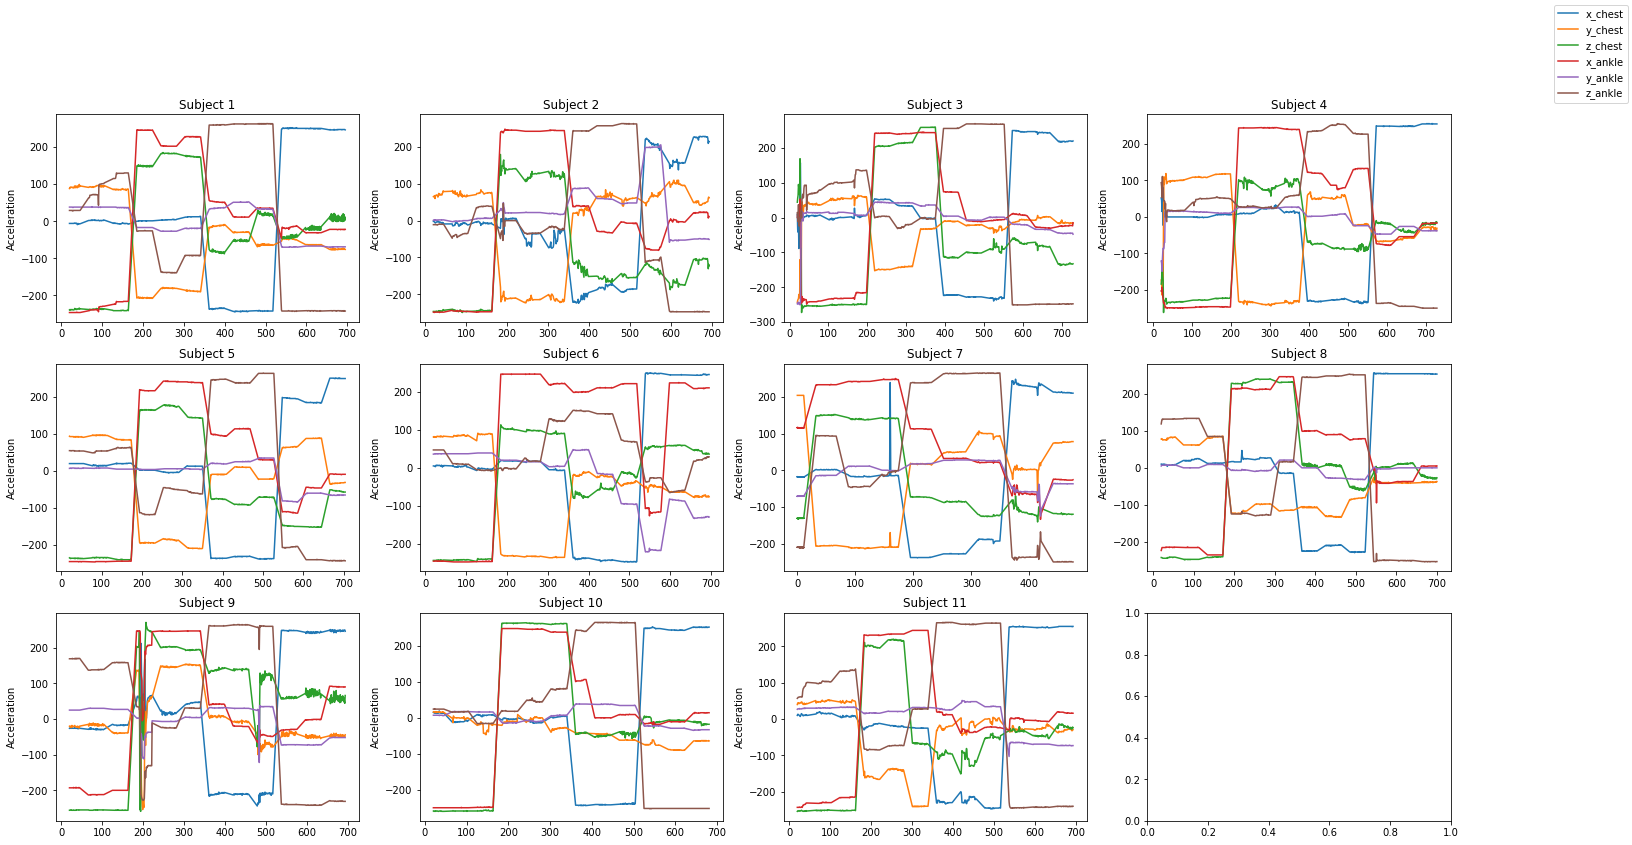

In [7]:
# Plot acceleration data for the 12 consecutive positions for each subject, after removal of the transient phases

fig, axs = plt.subplots(3, 4, figsize=(25,13))
axs = axs.flatten()
i = 0
subject_nb = 1

for data_subject in data_subjects_clean:
  axs[i].plot(data_subject[['x_chest', 'y_chest', 'z_chest', 'x_ankle', 'y_ankle', 'z_ankle']])
  axs[i].set_title('Subject {}'.format(subject_nb))
  axs[i].set_ylabel('Acceleration')
  subject_nb += 1
  i += 1

fig.legend(['x_chest', 'y_chest', 'z_chest', 'x_ankle', 'y_ankle', 'z_ankle'])
plt.show()

From these new graphs, it can be noticed that the lines were smoothed. \
These plots also show that the subject 9 presents erroneous data, as expected, since during data acquisition sensors fell off several times. \
Let's combine all the datasets together.

In [8]:
all_data = pd.DataFrame()
id = 1

for data_subject in data_subjects_clean:
  data_subject['subject_id'] = [id for i in range(data_subject.shape[0])]   # Add subject_id column to the concatenated dataset
  id += 1
  all_data = pd.concat([all_data, data_subject])

all_data

,x_chest,y_chest,z_chest,x_ankle,y_ankle,z_ankle,position,subject_id
20,-6,88,-239,-246,38,29,1,1
21,-6,91,-238,-246,38,29,1,1
22,-6,90,-239,-246,38,29,1,1
23,-6,92,-238,-246,38,29,1,1
24,-6,91,-239,-246,38,29,1,1
...,...,...,...,...,...,...,...,...
689,255,-30,-25,16,-73,-240,12,11
690,255,-32,-28,17,-74,-240,12,11
691,254,-32,-27,16,-73,-241,12,11
692,255,-31,-22,16,-73,-240,12,11


## Data standardization

An important step of the data preparation is to standardize it. Even though in our case all the features that will be used by the model are on the same scale (6 acceleration coordinates), it is always better to scale them in order to have lower values, helping the models to learn. \
This standardization aims to visualize only the data thanks to boxplots. Later on, the standardization will be performed on the created datasets, paying attention to the train-test splitting.

In [9]:
scaler = StandardScaler().fit(all_data.iloc[:,:6])
all_data.iloc[:,:6] = scaler.transform(all_data.iloc[:,:6])

all_data

,x_chest,y_chest,z_chest,x_ankle,y_ankle,z_ankle,position,subject_id
20,-0.058098,1.180467,-1.293748,-1.538354,0.851375,0.074628,1,1
21,-0.058098,1.209955,-1.287309,-1.538354,0.851375,0.074628,1,1
22,-0.058098,1.200125,-1.293748,-1.538354,0.851375,0.074628,1,1
23,-0.058098,1.219784,-1.287309,-1.538354,0.851375,0.074628,1,1
24,-0.058098,1.209955,-1.293748,-1.538354,0.851375,0.074628,1,1
...,...,...,...,...,...,...,...,...
689,1.504139,0.020613,0.084022,-0.021797,-1.478859,-1.431801,12,11
690,1.504139,0.000954,0.064707,-0.016009,-1.499852,-1.431801,12,11
691,1.498153,0.000954,0.071145,-0.021797,-1.478859,-1.437401,12,11
692,1.504139,0.010784,0.103336,-0.021797,-1.478859,-1.431801,12,11


Text(0.5, 1.0, 'Position 11')

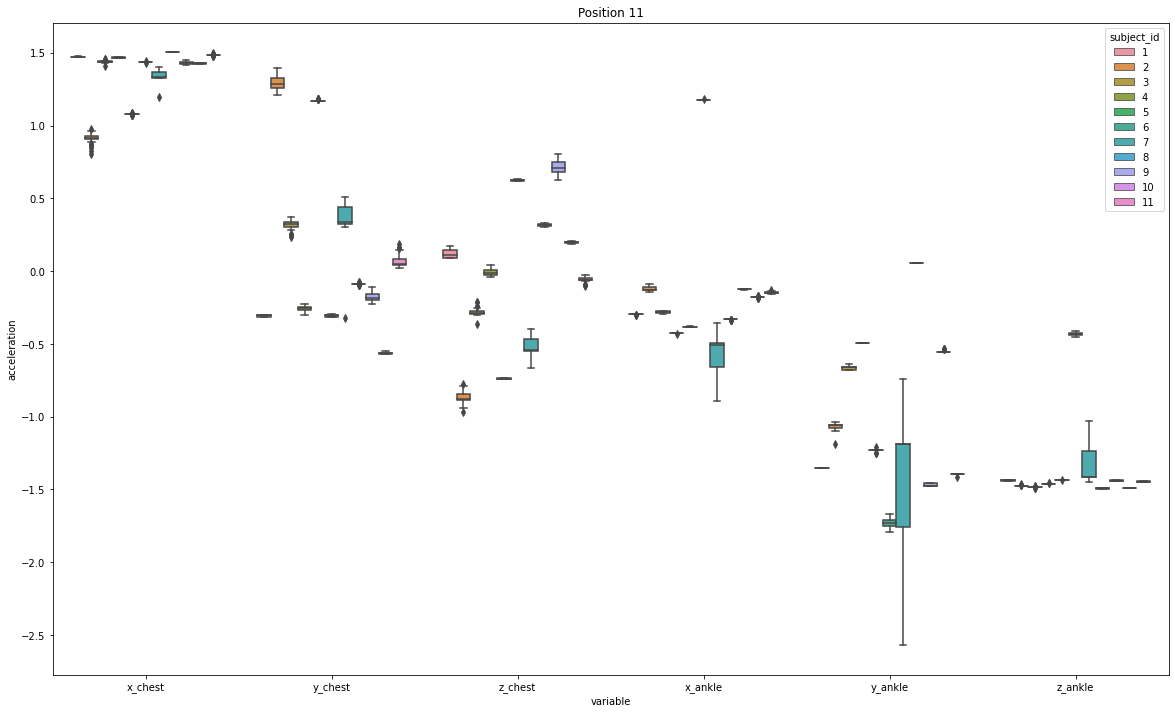

In [10]:
# Boxplots of the acceleration data grouped by subject, for each position and each x/y/z

all_data_copy = all_data.copy()
position_to_plot = 11   # Change here the position to plot

# Select the position requested
all_data_copy = all_data_copy.loc[all_data_copy.position == position_to_plot]
all_data_copy.drop(['position'], axis=1, inplace=True)

all_data_melt = pd.melt(all_data_copy, id_vars=['subject_id'])
all_data_melt.columns = ['subject_id', 'variable', 'acceleration']
plt.figure(figsize=(20,12))
sns.boxplot(x='variable', y='acceleration', hue='subject_id', data=all_data_melt)
plt.title('Position {}'.format(position_to_plot))

From the boxplots, by varying the positions from 1 to 12, we noticed the following anomalies:


*   Positions 4 and 9, Subject 9
*   Position 8, Subject 11
*   Position 10, y_ankle
*   Position 11, Subject 7
*   Position 12, Subject 5



## Features computation and dataset creation

After having performed data visualization, this section aims to start back with the raw data and apply the needed transformations to create our datasets. The transient phases between positions are removed and the averages, min and max of acceleration data are extracted as features. \
Three datasets are created:


*   A dataset containing all the samples for the 6 coordinates except the transient phases - Dataset 1
*   A dataset containing the 6 coordinates averages - Dataset 2
*   A dataset containing the averages, the min and the max of the 6 coordinates - Dataset 3



#### Dataset 1

In [11]:
# Remove the transient samplings between 2 positions for each subject and create a dataset

subject_list = ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'm01', 'm02', 'm03', 'm04']
id = 1
position_indexes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
dataset = pd.DataFrame()

for i in range(len(subject_list)):
  # Get identifier and sex of the subject
  sex = subject_list[i][0].upper()

  # Clean the subject's data by removing the transient portions
  subject_data = pd.DataFrame(data_subjects[i].copy())
  subject_data['subject_id'] = [id for i in range(subject_data.shape[0])]
  subject_data['sex'] = [sex for i in range(subject_data.shape[0])]

  for pos_idx in position_indexes:
    position_data = subject_data.loc[subject_data['position']==pos_idx]

    if position_data.shape[0] != 0:

      # Remove the 20 first rows for each position if more than 20 samples are present
      if position_data.shape[0] > 20:
        position_data_cleaned = position_data.iloc[20:,:]
        
      else:
        position_data_cleaned = position_data

      dataset = pd.concat([dataset, position_data_cleaned])

  id += 1
  
dataset.tail()

,x_chest,y_chest,z_chest,x_ankle,y_ankle,z_ankle,position,subject_id,sex
689,255,-30,-25,16,-73,-240,12,11,M
690,255,-32,-28,17,-74,-240,12,11,M
691,254,-32,-27,16,-73,-241,12,11,M
692,255,-31,-22,16,-73,-240,12,11,M
693,255,-29,-24,16,-73,-240,12,11,M


In [12]:
dataset.subject_id.value_counts()   # Sanity check of correct dataset creation

3     490
4     490
5     465
8     461
1     456
6     456
2     455
9     455
11    454
10    442
7     316
Name: subject_id, dtype: int64

#### Dataset 2

In [13]:
# Remove the transient samplings between 2 positions for each subject, take the averages and concatenate data into a single dataset

subject_list = ['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'm01', 'm02', 'm03', 'm04']
id = 1
acceleration_avgs = []
position_indexes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for i in range(len(subject_list)):
  # Get identifier and sex of the subject
  sex = subject_list[i][0].upper()

  # Clean the subject's data by removing the transient portions
  subject_data = pd.DataFrame(data_subjects[i])
  for pos_idx in position_indexes:
    position_data = subject_data.loc[subject_data['position']==pos_idx]

    if position_data.shape[0] != 0:

      # Remove the 20 first rows for each position if more than 20 samples are present
      if position_data.shape[0] > 20:
        position_data_cleaned = position_data.iloc[20:,:]
      else:
        position_data_cleaned = position_data

      # Compute and store the averages, min and max
      avg_min_max = []
      avg_min_max.append(id)
      avg_min_max.append(sex)
      for column in position_data_cleaned.columns.drop(['position']):
        acc_values = position_data_cleaned[column]
        avg_min_max.append(acc_values.mean())
        avg_min_max.append(min(acc_values))
        avg_min_max.append(max(acc_values))

      avg_min_max.append(pos_idx)

      acceleration_avgs.append(avg_min_max)

  id += 1
  
dataset_avg_min_max = pd.DataFrame(acceleration_avgs, columns = ['subject_id', 'sex', 'x_chest_avg', 'x_chest_min', 'x_chest_max', 'y_chest_avg', 'y_chest_min', 'y_chest_max', 'z_chest_avg', 'z_chest_min', 'z_chest_max', 'x_ankle_avg', 'x_ankle_min', 'x_ankle_max', 'y_ankle_avg', 'y_ankle_min', 'y_ankle_max', 'z_ankle_avg', 'z_ankle_min', 'z_ankle_max', 'position'])

dataset_avg_min_max.head()

,subject_id,sex,x_chest_avg,x_chest_min,x_chest_max,y_chest_avg,y_chest_min,y_chest_max,z_chest_avg,z_chest_min,...,x_ankle_avg,x_ankle_min,x_ankle_max,y_ankle_avg,y_ankle_min,y_ankle_max,z_ankle_avg,z_ankle_min,z_ankle_max,position
0,1,F,-6.333333,-9,-5,92.296296,88,99,-237.370370,-239,...,-245.962963,-246,-245,37.925926,37,38,28.925926,28,29,1
1,1,F,2.230769,1,4,93.615385,91,96,-236.897436,-238,...,-235.871795,-244,-229,38.000000,37,39,80.307692,43,103,2
2,1,F,-6.230769,-8,-4,85.461538,83,88,-240.769231,-241,...,-218.076923,-224,-216,37.000000,36,38,126.230769,114,130,3
3,1,F,0.769231,0,1,-206.487179,-208,-204,148.564103,146,...,245.282051,245,246,-17.000000,-17,-17,-26.051282,-27,-25,4
4,1,F,3.871795,3,5,-180.461538,-182,-178,182.538462,182,...,202.256410,202,203,-26.948718,-27,-26,-138.256410,-139,-137,5


In [14]:
dataset_avg_min_max.subject_id.value_counts()

1     12
2     12
3     12
4     12
5     12
6     12
8     12
9     12
10    12
11    12
7     10
Name: subject_id, dtype: int64

#### Dataset 3

In [15]:
# Define the dataset containing only the averages by selecting the appropriate columns from the previously created dataset

dataset_avg = dataset_avg_min_max[['subject_id', 'sex', 'x_chest_avg', 'y_chest_avg', 'z_chest_avg', 'x_ankle_avg', 'y_ankle_avg', 'z_ankle_avg', 'position']]

In [16]:
dataset_avg.loc[dataset_avg['subject_id']==1]

,subject_id,sex,x_chest_avg,y_chest_avg,z_chest_avg,x_ankle_avg,y_ankle_avg,z_ankle_avg,position
0,1,F,-6.333333,92.296296,-237.370370,-245.962963,37.925926,28.925926,1
1,1,F,2.230769,93.615385,-236.897436,-235.871795,38.000000,80.307692,2
2,1,F,-6.230769,85.461538,-240.769231,-218.076923,37.000000,126.230769,3
3,1,F,0.769231,-206.487179,148.564103,245.282051,-17.000000,-26.051282,4
4,1,F,3.871795,-180.461538,182.538462,202.256410,-26.948718,-138.256410,5
5,1,F,11.846154,-188.076923,174.000000,227.538462,-19.282051,-92.256410,6
6,1,F,-235.384615,-13.051282,-82.205128,52.230769,34.974359,259.358974,7
7,1,F,-242.897436,-29.846154,-52.307692,11.205128,51.153846,261.871795,8
8,1,F,-241.794872,-63.820513,19.461538,35.102564,32.589744,262.384615,9
9,1,F,250.282051,-48.179487,-43.000000,-17.435897,-69.615385,-241.974359,10


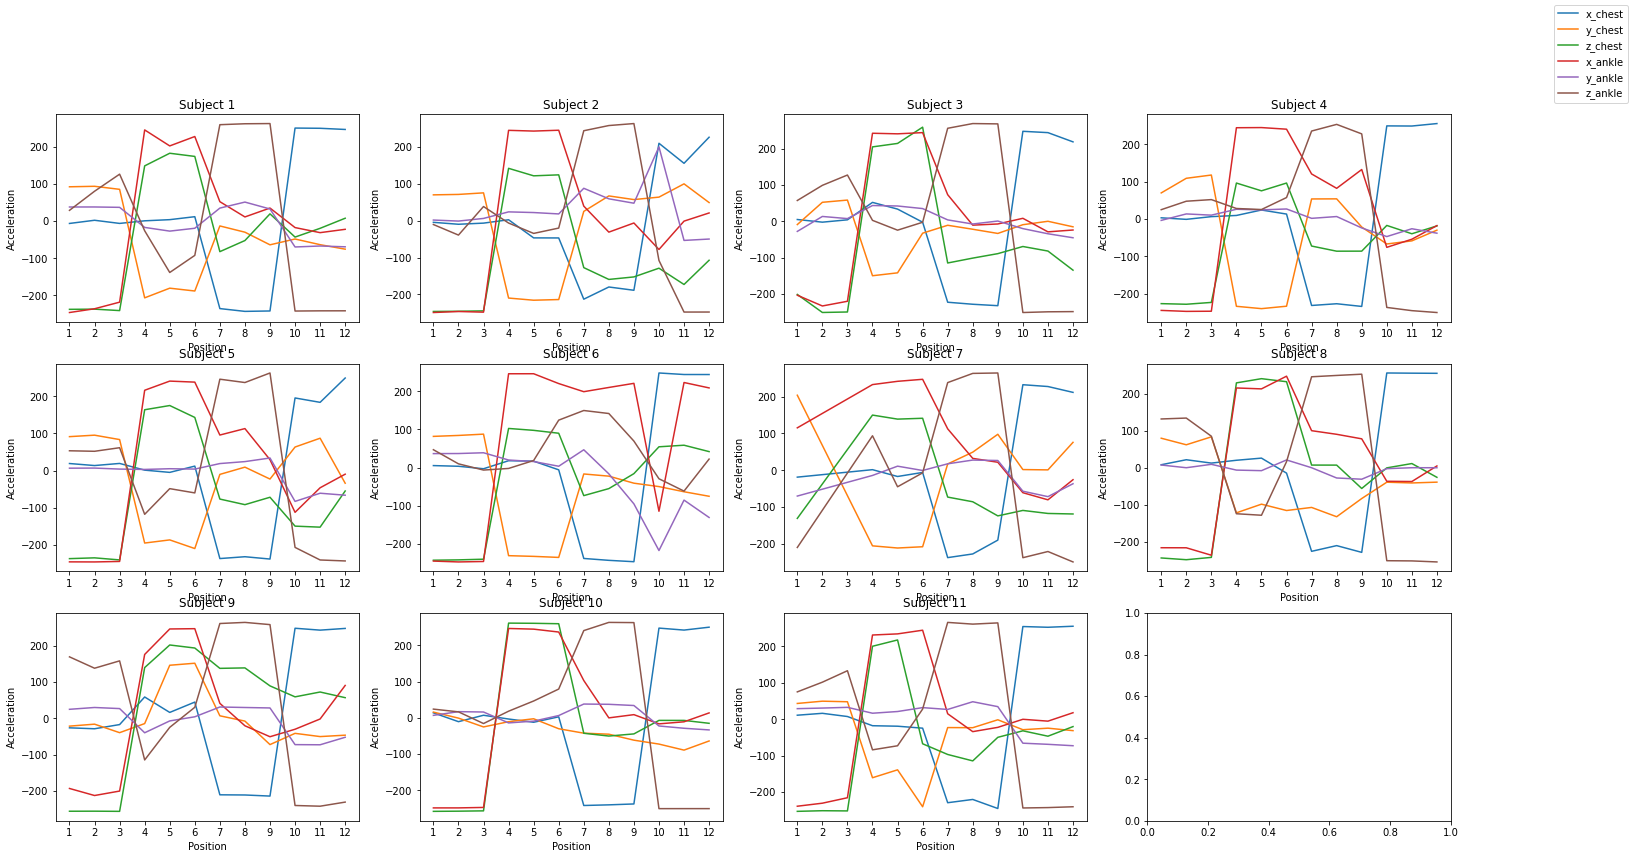

In [17]:
# Plot of averaged acceleration data for the 12 consecutive positions for each subject after removing the transient phases

fig, axs = plt.subplots(3, 4, figsize=(25,13))
axs = axs.flatten()
i = 0
subject_nb = 1

for id in range(1,12):
  axs[i].plot(dataset_avg.loc[dataset_avg['subject_id']==id][['position']], dataset_avg.loc[dataset_avg['subject_id']==id][['x_chest_avg', 'y_chest_avg', 'z_chest_avg', 'x_ankle_avg', 'y_ankle_avg', 'z_ankle_avg']])
  axs[i].set_title('Subject {}'.format(subject_nb))
  axs[i].set_ylabel('Acceleration')
  axs[i].set_xlabel('Position')
  axs[i].set_xticks([i for i in range(1,13)])
  subject_nb += 1
  i += 1

fig.legend(['x_chest', 'y_chest', 'z_chest', 'x_ankle', 'y_ankle', 'z_ankle'])
plt.show()

In [18]:
dataset.reset_index(inplace=True, drop=True)

In [19]:
# Remove corrupeted data from the 3 datasets - subject_m02 entirely (9)
dataset.drop(dataset[dataset.subject_id == 9].index, inplace=True)
dataset_avg_min_max.drop(dataset_avg_min_max[dataset_avg_min_max.subject_id == 9].index, inplace=True)
dataset_avg.drop(dataset_avg[dataset_avg.subject_id == 9].index, inplace=True)

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [20]:
dataset.head()

,x_chest,y_chest,z_chest,x_ankle,y_ankle,z_ankle,position,subject_id,sex
0,-6,88,-239,-246,38,29,1,1,F
1,-6,91,-238,-246,38,29,1,1,F
2,-6,90,-239,-246,38,29,1,1,F
3,-6,92,-238,-246,38,29,1,1,F
4,-6,91,-239,-246,38,29,1,1,F


In [21]:
dataset.shape, dataset_avg.shape, dataset_avg_min_max.shape

((4485, 9), (118, 9), (118, 21))

## Train-test split

This section aims to split the 3 created datasets in train and test sets, keeping 7 subjects in the train set and 3 subjects in the test set.

In [22]:
# For dataset

gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=123)
gss.get_n_splits()

X = dataset.drop(['sex', 'position'], axis=1)
position = dataset['position']
subject_id = dataset['subject_id']
columns = list(dataset.columns)
columns.remove('sex')
columns.remove('position')

# Split with respect to subject_id to prevent a subject from being in both train and test sets
for train_idx, test_idx in gss.split(X, position, subject_id):
    X_train = np.array(X)[train_idx]
    y_train = np.array(position)[train_idx]
    X_test = np.array(X)[test_idx]
    y_test = np.array(position)[test_idx]

X_train = pd.DataFrame(X_train, columns=columns)
y_train = pd.DataFrame(y_train, columns=['position'])
X_test = pd.DataFrame(X_test, columns=columns)
y_test = pd.DataFrame(y_test, columns=['position'])

print(X_train['subject_id'].value_counts(), X_test['subject_id'].value_counts())

# Concatenate X and y to shuffle the data
df_train = pd.concat([X_train, y_train], axis = 1)
df_train = df_train.sample(frac=1)
df_test = pd.concat([X_test, y_test], axis = 1)
df_test = df_test.sample(frac=1)

# Shuffle the data
X_train = df_train.drop(['position'], axis=1)
y_train = df_train[['position']]
X_test = df_test.drop(['position'], axis=1)
y_test = df_test['position']

3     490
4     490
6     456
2     455
11    454
10    442
7     316
Name: subject_id, dtype: int64 5    465
8    461
1    456
Name: subject_id, dtype: int64


In [23]:
# For dataset_avg

gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=123)
gss.get_n_splits()

X = dataset_avg.drop(['sex', 'position'], axis=1)
position = dataset_avg['position']
subject_id = dataset_avg['subject_id']
columns = list(dataset_avg.columns)
columns.remove('sex')
columns.remove('position')

# Split with respect to subject_id to prevent a subject from being in both train and test sets
for train_idx, test_idx in gss.split(X, position, subject_id):
    X_train_avg = np.array(X)[train_idx]
    y_train_avg = np.array(position)[train_idx]
    X_test_avg = np.array(X)[test_idx]
    y_test_avg = np.array(position)[test_idx]

X_train_avg = pd.DataFrame(X_train_avg, columns=columns)
y_train_avg = pd.DataFrame(y_train_avg, columns=['position'])
X_test_avg = pd.DataFrame(X_test_avg, columns=columns)
y_test_avg = pd.DataFrame(y_test_avg, columns=['position'])

print(X_train_avg['subject_id'].value_counts(), X_test_avg['subject_id'].value_counts())

# Concatenate X and y to shuffle the data
df_train_avg = pd.concat([X_train_avg, y_train_avg], axis = 1)
df_train_avg = df_train_avg.sample(frac=1)
df_test_avg = pd.concat([X_test_avg, y_test_avg], axis = 1)
df_test_avg = df_test_avg.sample(frac=1)

# Shuffle the data
X_train_avg = df_train_avg.drop(['position'], axis=1)
y_train_avg = df_train_avg[['position']]
X_test_avg = df_test_avg.drop(['position'], axis=1)
y_test_avg = df_test_avg['position']

2.0     12
3.0     12
4.0     12
6.0     12
10.0    12
11.0    12
7.0     10
Name: subject_id, dtype: int64 1.0    12
5.0    12
8.0    12
Name: subject_id, dtype: int64


In [24]:
# For dataset_avg_min_max

gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=123)
gss.get_n_splits()

X = dataset_avg_min_max.drop(['sex', 'position'], axis=1)
position = dataset_avg_min_max['position']
subject_id = dataset_avg_min_max['subject_id']
columns = list(dataset_avg_min_max.columns)
columns.remove('sex')
columns.remove('position')

# Split with respect to subject_id to prevent a subject from being in both train and test sets
for train_idx, test_idx in gss.split(X, position, subject_id):
    X_train_avg_min_max = np.array(X)[train_idx]
    y_train_avg_min_max = np.array(position)[train_idx]
    X_test_avg_min_max = np.array(X)[test_idx]
    y_test_avg_min_max = np.array(position)[test_idx]

X_train_avg_min_max = pd.DataFrame(X_train_avg_min_max, columns=columns)
y_train_avg_min_max = pd.DataFrame(y_train_avg_min_max, columns=['position'])
X_test_avg_min_max = pd.DataFrame(X_test_avg_min_max, columns=columns)
y_test_avg_min_max = pd.DataFrame(y_test_avg_min_max, columns=['position'])

print(X_train_avg_min_max['subject_id'].value_counts(), X_test_avg_min_max['subject_id'].value_counts())

# Concatenate X and y to shuffle the data
df_train_avg_min_max = pd.concat([X_train_avg_min_max, y_train_avg_min_max], axis = 1)
df_train_avg_min_max = df_train_avg_min_max.sample(frac=1)
df_test_avg_min_max = pd.concat([X_test_avg_min_max, y_test_avg_min_max], axis = 1)
df_test_avg_min_max = df_test_avg_min_max.sample(frac=1)

# Shuffle the data
X_train_avg_min_max = df_train_avg_min_max.drop(['position'], axis=1)
y_train_avg_min_max = df_train_avg_min_max[['position']]
X_test_avg_min_max = df_test_avg_min_max.drop(['position'], axis=1)
y_test_avg_min_max = df_test_avg_min_max['position']

2.0     12
3.0     12
4.0     12
6.0     12
10.0    12
11.0    12
7.0     10
Name: subject_id, dtype: int64 1.0    12
5.0    12
8.0    12
Name: subject_id, dtype: int64


## Dataset standardization

Before training the models, we need to standardize the three created datasets. \
It is important to learn the scaler on the train set only and to use it to scale both the train and test sets, to avoid including information from the test set in the training phase.

In [25]:
# For dataset
# Learn scaler on train set
scaler = StandardScaler().fit(X_train.iloc[:,:-1])

# Standardize train set
X_train.iloc[:,:-1] = scaler.transform(X_train.iloc[:,:-1])

# Standardize test set
X_test.iloc[:,:-1] = scaler.transform(X_test.iloc[:,:-1])

In [26]:
X_train.head()

,x_chest,y_chest,z_chest,x_ankle,y_ankle,z_ankle,subject_id
1562,0.097708,-1.892379,1.013774,1.246656,0.363224,-0.132797,6
2160,1.342199,0.359708,-0.487620,-0.515242,-1.115937,-1.511267,7
1301,-1.433972,0.137399,-0.153977,0.610572,-0.452211,1.210478,4
1773,-1.481837,0.002081,0.166321,1.105929,-1.798627,0.277811,6
1352,1.473828,-0.307219,0.199685,-0.577162,-0.888374,-1.505401,4


In [27]:
# For dataset_avg
# Learn scaler on train set
scaler = StandardScaler().fit(X_train_avg.iloc[:,1:])

# Standardize train set
X_train_avg.iloc[:,1:] = scaler.transform(X_train_avg.iloc[:,1:])

# Standardize test set
X_test_avg.iloc[:,1:] = scaler.transform(X_test_avg.iloc[:,1:])

In [28]:
# For dataset_avg_min_max
# Learn scaler on train set
scaler = StandardScaler().fit(X_train_avg_min_max.iloc[:,1:])

# Standardize train set
X_train_avg_min_max.iloc[:,1:] = scaler.transform(X_train_avg_min_max.iloc[:,1:])

# Standardize test set
X_test_avg_min_max.iloc[:,1:] = scaler.transform(X_test_avg_min_max.iloc[:,1:])

## Supervised Learning

This section presents the hyperp_search function used to perform grid search and cross-validation, followed by all the models used for training, the best model found (parameters combination) for each of them and the performances on the test set. \
At first, all the models are performed on the first dataset, and then the best ones are also applied to datasets 2 and 3.

In [29]:
def hyperp_search(classifier, parameters, k, X_train, y_train, X_test, y_test):
    ''' This function takes as input a classifier (e.g. Decision Tree), a dictionary of parameters, the number of folds k for the cross-valdiation,
                                     the train (X_train, y_train) and the test (X_test, y_test) sets
                      performs a grid search using the cross-validation method and stores the best set of parameters looking at the performances on the validation sets
                      prints the different metrics on the train and the test sets
                      returns the best model fitted (refit=True) on the best set of parameters found
    '''

    # Hyperparameter tuning via cross-validation
    gs = GridSearchCV(classifier, parameters, cv=k, scoring = 'accuracy', refit=True, verbose=0, n_jobs=-1) # refit=True refits the model with the best found parameters on the whole dataset
    gs = gs.fit(X_train, y_train)

    # Prediction on train and test sets with best model found
    best_model = gs.best_estimator_
    y_test_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)

    # Results display
    print("\n \033[1m ***Best result obtained*** \033[0m \n")
    print("accuracy (mean cross-validated score): %f using %s" % (gs.best_score_, gs.best_params_))

    print("\n \033[1m ***Scores obtained on train and test sets with best model*** \033[0m \n")
    print("f1          train %.3f   test %.3f" % (f1_score(y_train, y_train_pred, average='macro'), f1_score(y_test, y_test_pred, average='macro'))) 
    print("recall      train %.3f   test %.3f" % (recall_score(y_train, y_train_pred, average='macro'), recall_score(y_test, y_test_pred, average='macro'))) 
    print("precision   train %.3f   test %.3f" % (precision_score(y_train, y_train_pred, average='macro'), precision_score(y_test, y_test_pred, average='macro'))) 
    print("accuracy    train %.3f   test %.3f" % (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))) 

    print("\n \033[1m ***Classification report on test set*** \033[0m \n")
    print(classification_report(y_test, y_test_pred, target_names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']))

    print("\n \033[1m ***Confusion matrix on test set*** \033[0m \n")
    plot_confusion_matrix(best_model, X_test, y_test, display_labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], values_format='', cmap='Reds')

    return best_model

### On dataset with averages

#### KNN

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMe


  ***Best result obtained***  

accuracy (mean cross-validated score): 0.184559 using {'n_neighbors': 6}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.243   test 0.178
recall      train 0.345   test 0.306
precision   train 0.224   test 0.132
accuracy    train 0.354   test 0.306

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.33      0.67      0.44         3
           2       0.33      0.33      0.33         3
           3       0.00      0.00      0.00         3
           4       0.33      1.00      0.50         3
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         3
           7       0.25      0.67      0.36         3
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         3
          10       0.33      1.00      0.50         3
          11       0.00      0.00     

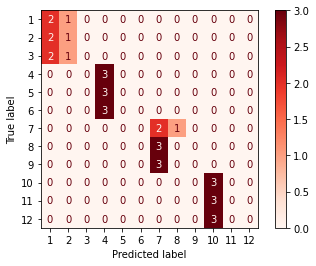

In [30]:
classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(3,50,1)}

best_model_knn_avg = hyperp_search(classifier, parameters, 5, X_train_avg, y_train_avg, X_test_avg, y_test_avg)

#### Decision Tree


  ***Best result obtained***  

accuracy (mean cross-validated score): 0.343382 using {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 5}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.531   test 0.331
recall      train 0.587   test 0.417
precision   train 0.516   test 0.405
accuracy    train 0.585   test 0.417

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.33      0.33      0.33         3
           3       0.40      0.67      0.50         3
           4       0.00      0.00      0.00         3
           5       0.38      1.00      0.55         3
           6       1.00      0.33      0.50         3
           7       0.38      1.00      0.55         3
           8       1.00      0.33      0.50         3
           9       0.00      0.00      0.00         3
          10       0.38

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sk

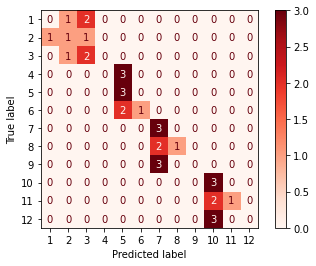

In [31]:
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [4,5,6],
              'min_samples_split': [3,5],
              'min_samples_leaf': [3,5]}

best_model_tree_avg = hyperp_search(classifier, parameters, 5, X_train_avg, y_train_avg, X_test_avg, y_test_avg)

In [32]:
r = tree.export_text(best_model_tree_avg, feature_names=X_test_avg.columns.tolist(), max_depth=5)
print(r)

|--- x_chest_avg <= -0.69
|   |--- x_ankle_avg <= -0.07
|   |   |--- class: 8
|   |--- x_ankle_avg >  -0.07
|   |   |--- y_ankle_avg <= 0.54
|   |   |   |--- class: 7
|   |   |--- y_ankle_avg >  0.54
|   |   |   |--- class: 7
|--- x_chest_avg >  -0.69
|   |--- x_chest_avg <= 0.61
|   |   |--- z_chest_avg <= -0.32
|   |   |   |--- y_ankle_avg <= 0.09
|   |   |   |   |--- class: 1
|   |   |   |--- y_ankle_avg >  0.09
|   |   |   |   |--- x_chest_avg <= 0.01
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- x_chest_avg >  0.01
|   |   |   |   |   |--- class: 3
|   |   |--- z_chest_avg >  -0.32
|   |   |   |--- z_ankle_avg <= -0.23
|   |   |   |   |--- class: 5
|   |   |   |--- z_ankle_avg >  -0.23
|   |   |   |   |--- x_chest_avg <= -0.04
|   |   |   |   |   |--- class: 6
|   |   |   |   |--- x_chest_avg >  -0.04
|   |   |   |   |   |--- x_ankle_avg <= 1.24
|   |   |   |   |   |   |--- class: 4
|   |   |   |   |   |--- x_ankle_avg >  1.24
|   |   |   |   |   |   |--- class: 4
|   |--

#### Random Forest

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  warnings.warn(
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted s


  ***Best result obtained***  

accuracy (mean cross-validated score): 0.330087 using {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.540   test 0.319
recall      train 0.571   test 0.389
precision   train 0.580   test 0.320
accuracy    train 0.573   test 0.389

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         3
           3       0.29      0.67      0.40         3
           4       0.40      0.67      0.50         3
           5       0.50      0.67      0.57         3
           6       0.00      0.00      0.00         3
           7       0.50      1.00      0.67         3
           8       0.50      0.33      0.40         3
           9       1.00      0.33      0.50         3
      

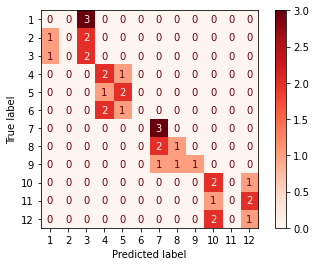

In [33]:
classifier = RandomForestClassifier()
parameters = {'n_estimators': [10, 20], 
              'criterion': ['entropy', 'gini'], 
              'max_depth': [4, 5, 6],
              'min_samples_split': [3, 5],   
              'min_samples_leaf': [3, 5]}  

best_model_rf_avg = hyperp_search(classifier, parameters, 7, X_train_avg, y_train_avg, X_test_avg, y_test_avg)

#### Adaboost

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



  ***Best result obtained***  

accuracy (mean cross-validated score): 0.280882 using {'learning_rate': 0.001, 'n_estimators': 1500}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.259   test 0.165
recall      train 0.381   test 0.306
precision   train 0.373   test 0.114
accuracy    train 0.390   test 0.306

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.33      1.00      0.50         3
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         3
           6       0.50      1.00      0.67         3
           7       0.33      1.00      0.50         3
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         3
          10       0.20      0.67      0.31         3
          

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sk

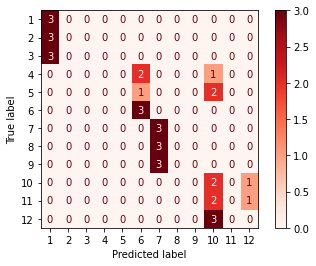

In [34]:
classifier= AdaBoostClassifier()
parameters = {'n_estimators' : np.arange(1500,2500,500),
              'learning_rate' : [0.001,0.01,0.1]}

best_model_adaboost_avg = hyperp_search(classifier, parameters, 5, X_train_avg, y_train_avg, X_test_avg, y_test_avg)

#### XGBoost

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or

[10:18:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

  ***Best result obtained***  

accuracy (mean cross-validated score): 0.205882 using {'gamma': 2, 'max_depth': 3, 'n_estimators': 10, 'reg_alpha': 2, 'reg_lambda': 0}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.481   test 0.279
recall      train 0.554   test 0.389
precision   train 0.588   test 0.228
accuracy    train 0.549   test 0.389

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.33      0.67      0.44         3
           3       0.33      0.33      0.33         3
           4       0.33      1.00      0.50         3
           5       0.00      0.00      0.00   

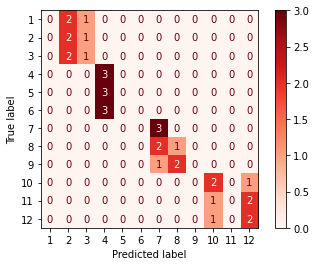

In [35]:
classifier = xgb.XGBClassifier()
parameters = {'max_depth': [3,4,5], 
              'n_estimators': [10,20,30], 
              'reg_lambda': [0,1,2],
              'reg_alpha': [0,1,2],
              'gamma': [1,2,3]}

best_model_xgb_avg = hyperp_search(classifier, parameters, 5, X_train_avg, y_train_avg, X_test_avg, y_test_avg)

#### Logistic Regression

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318


  ***Best result obtained***  

accuracy (mean cross-validated score): 0.123529 using {'C': 1, 'max_iter': 10000, 'penalty': 'l2'}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.451   test 0.286
recall      train 0.458   test 0.333
precision   train 0.458   test 0.279
accuracy    train 0.463   test 0.333

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.33      0.67      0.44         3
           2       0.00      0.00      0.00         3
           3       0.50      0.33      0.40         3
           4       0.50      0.33      0.40         3
           5       0.43      1.00      0.60         3
           6       0.00      0.00      0.00         3
           7       0.50      0.33      0.40         3
           8       0.25      0.33      0.29         3
           9       0.33      0.33      0.33         3
          10       0.25      0.33      0.29         3
          11

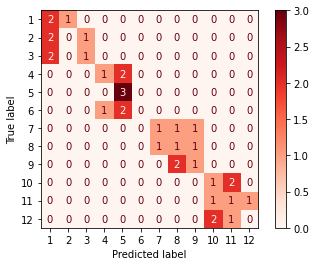

In [36]:
classifier = LogisticRegression()
parameters = {"C":[0.01,0.1,1],
              "max_iter":[10000],
              "penalty":['l2']}

best_model_lr_avg = hyperp_search(classifier, parameters, 5, X_train_avg, y_train_avg, X_test_avg, y_test_avg)

#### SVM

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMe


  ***Best result obtained***  

accuracy (mean cross-validated score): 0.172794 using {'C': 0.1, 'kernel': 'linear'}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.374   test 0.258
recall      train 0.429   test 0.361
precision   train 0.478   test 0.270
accuracy    train 0.439   test 0.361

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.33      1.00      0.50         3
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       1.00      0.33      0.50         3
           5       0.38      1.00      0.55         3
           6       0.00      0.00      0.00         3
           7       0.50      0.33      0.40         3
           8       0.20      0.33      0.25         3
           9       0.50      0.33      0.40         3
          10       0.00      0.00      0.00         3
          11       0.33   

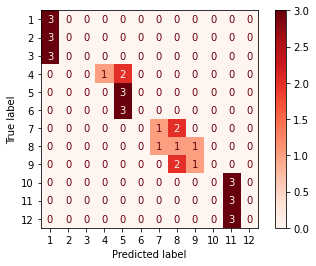

In [37]:
classifier = SVC()
parameters = {"kernel":['linear'],
              "C":[0.01,0.1]}

best_model_svm_avg = hyperp_search(classifier, parameters, 5, X_train_avg, y_train_avg, X_test_avg, y_test_avg)

#### MLP

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defi


  ***Best result obtained***  

accuracy (mean cross-validated score): 0.293382 using {'alpha': 1, 'hidden_layer_sizes': (10, 8, 5), 'max_iter': 1000}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.448   test 0.327
recall      train 0.460   test 0.389
precision   train 0.446   test 0.374
accuracy    train 0.463   test 0.389

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.33      0.33      0.33         3
           2       0.40      0.67      0.50         3
           3       0.33      0.33      0.33         3
           4       0.38      1.00      0.55         3
           5       0.00      0.00      0.00         3
           6       1.00      0.33      0.50         3
           7       0.38      1.00      0.55         3
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         3
          10       0.33      0.33      0.33   

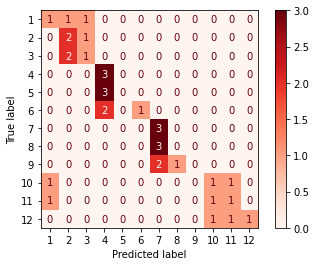

In [38]:
classifier = MLPClassifier()
parameters = {"hidden_layer_sizes":[(16,8), (10,8,5)],  "max_iter": [500, 1000], "alpha": [1]}

best_model_mlp_avg = hyperp_search(classifier, parameters, 5, X_train_avg, y_train_avg, X_test_avg, y_test_avg)

### On dataset with raw samples

#### Decision Tree


  ***Best result obtained***  

accuracy (mean cross-validated score): 0.788271 using {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 3}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.803   test 0.350
recall      train 0.808   test 0.400
precision   train 0.860   test 0.366
accuracy    train 0.813   test 0.405

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.01      0.01      0.01        98
           2       0.46      0.45      0.46       117
           3       0.35      0.33      0.34       117
           4       0.41      0.68      0.51       117
           5       0.34      0.33      0.34       117
           6       1.00      0.32      0.48       114
           7       0.43      1.00      0.60       117
           8       0.00      0.00      0.00       117
           9       0.50      0.33      0.40       117
          10       0.50   

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\sit

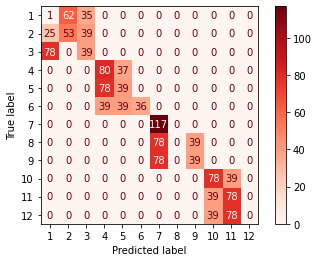

In [39]:
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [4,5,6],
              'min_samples_split': [3,5],
              'min_samples_leaf': [3,5]}

best_model_tree_raw = hyperp_search(classifier, parameters, 5, X_train, y_train, X_test, y_test)

#### Random Forest

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_cl


  ***Best result obtained***  

accuracy (mean cross-validated score): 0.969060 using {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 20}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.954   test 0.388
recall      train 0.954   test 0.414
precision   train 0.958   test 0.458
accuracy    train 0.956   test 0.415

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.24      0.37      0.29        98
           2       0.88      0.13      0.22       117
           3       0.24      0.33      0.28       117
           4       0.47      0.67      0.55       117
           5       0.53      0.67      0.59       117
           6       1.00      0.32      0.48       114
           7       0.59      0.67      0.63       117
           8       0.28      0.33      0.30       117
           9       0.50      0.33      0.40       117
   

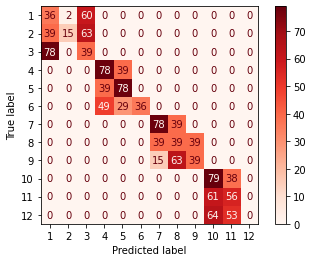

In [40]:
classifier = RandomForestClassifier()
parameters = {'n_estimators': [10, 20], 
              'criterion': ['entropy', 'gini'], 
              'max_depth': [4, 5, 6],
              'min_samples_split': [3, 5],   
              'min_samples_leaf': [3, 5]}  

best_model_rf_raw = hyperp_search(classifier, parameters, 7, X_train, y_train, X_test, y_test)

#### SVM

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



  ***Best result obtained***  

accuracy (mean cross-validated score): 0.487266 using {'C': 0.1, 'kernel': 'linear'}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.532   test 0.336
recall      train 0.551   test 0.393
precision   train 0.586   test 0.378
accuracy    train 0.557   test 0.390

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.38      0.64      0.48        98
           2       0.00      0.00      0.00       117
           3       0.31      0.33      0.32       117
           4       0.36      0.33      0.35       117
           5       0.50      1.00      0.67       117
           6       1.00      0.06      0.12       114
           7       0.40      0.67      0.50       117
           8       0.00      0.00      0.00       117
           9       0.50      0.67      0.57       117
          10       0.34      0.34      0.34       117
          11       0.50   

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\sit

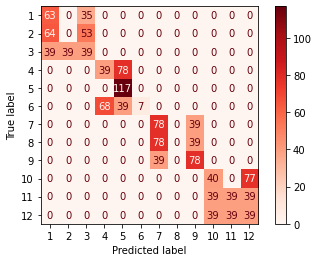

In [41]:
classifier = SVC()
parameters = {"kernel":['linear'],
              "C":[0.01,0.1]}

best_model_svm_raw = hyperp_search(classifier, parameters, 5, X_train, y_train, X_test, y_test)

Keeping all the data is increasing overfitting without meliorating the results. \
Indeed, this result was predictable since by keeping all the data recorded for each position, we are feeding the network the same data many times, making it more prone to overfitting.

### On dataset with averages, min and max

#### Decision Tree


  ***Best result obtained***  

accuracy (mean cross-validated score): 0.291912 using {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 3}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.581   test 0.295
recall      train 0.611   test 0.389
precision   train 0.583   test 0.328
accuracy    train 0.610   test 0.389

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.33      0.33      0.33         3
           3       0.40      0.67      0.50         3
           4       0.00      0.00      0.00         3
           5       0.38      1.00      0.55         3
           6       1.00      0.33      0.50         3
           7       0.33      1.00      0.50         3
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         3
          10       0.50

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sk

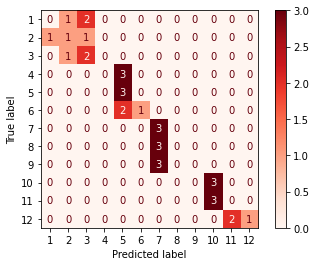

In [42]:
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [4,5,6],
              'min_samples_split': [3,5],
              'min_samples_leaf': [3,5]}

best_model_tree_avg_min_max = hyperp_search(classifier, parameters, 5, X_train_avg_min_max, y_train_avg_min_max, X_test_avg_min_max, y_test_avg_min_max)

#### Random Forest

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=7.
  warnings.warn(
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted s


  ***Best result obtained***  

accuracy (mean cross-validated score): 0.317100 using {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 10}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.527   test 0.356
recall      train 0.556   test 0.444
precision   train 0.531   test 0.371
accuracy    train 0.561   test 0.444

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.33      0.33      0.33         3
           2       0.00      0.00      0.00         3
           3       0.33      0.67      0.44         3
           4       0.43      1.00      0.60         3
           5       0.50      0.33      0.40         3
           6       0.00      0.00      0.00         3
           7       0.43      1.00      0.60         3
           8       0.00      0.00      0.00         3
           9       1.00      0.67      0.80         3
      

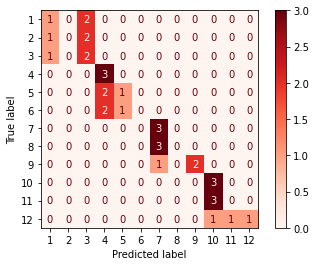

In [43]:
classifier = RandomForestClassifier()
parameters = {'n_estimators': [10, 20], 
              'criterion': ['entropy', 'gini'], 
              'max_depth': [4, 5, 6],
              'min_samples_split': [3, 5],   
              'min_samples_leaf': [3, 5]}  

best_model_rf_avg_min_max = hyperp_search(classifier, parameters, 7, X_train_avg_min_max, y_train_avg_min_max, X_test_avg_min_max, y_test_avg_min_max)

#### SVM

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMe


  ***Best result obtained***  

accuracy (mean cross-validated score): 0.158088 using {'C': 0.01, 'kernel': 'linear'}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.331   test 0.174
recall      train 0.393   test 0.306
precision   train 0.360   test 0.128
accuracy    train 0.402   test 0.306

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       0.33      1.00      0.50         3
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.33      1.00      0.50         3
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         3
           8       0.20      0.33      0.25         3
           9       0.33      0.33      0.33         3
          10       0.00      0.00      0.00         3
          11       0.33  

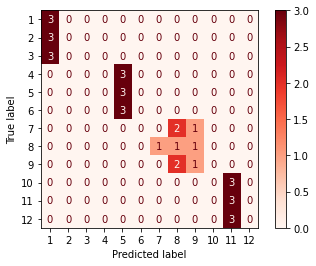

In [44]:
classifier = SVC()
parameters = {"kernel":['linear'],
              "C":[0.01,0.1]}

best_model_svm_avg_min_max = hyperp_search(classifier, parameters, 5, X_train_avg_min_max, y_train_avg_min_max, X_test_avg_min_max, y_test_avg_min_max)

The best result obtained is with Random Forest applied to this dataset, with which we are reaching 50% of accuracy on the test set. Even if the gap between train and test metrics is significant, there is no strong overfitting.

## Unsupervised Learning -- **TO COMPLETE**

In [45]:
X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y_test = pd.DataFrame(y_test, columns=['position'])
y = pd.concat([y_train, y_test], ignore_index=True)

### K-means

In [46]:
classifier = KMeans(12)
classifier.fit(X)

y_pred = classifier.predict(X)

# Calculate some metrics
print('The adjusted Rand index has a value of {0:.4f}'.format(adjusted_rand_score(np.array(y.position), y_pred)))
print('The Normalized Mutual Information has a value of {0:.4f}'.format(normalized_mutual_info_score(np.array(y.position), y_pred)))

The adjusted Rand index has a value of 0.2742
The Normalized Mutual Information has a value of 0.5442


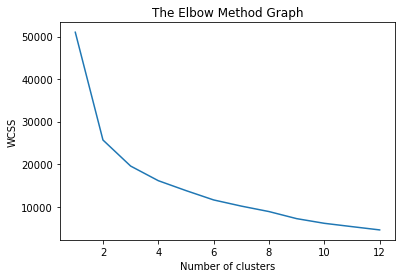

In [47]:
wcss = []
#this loop will fit the k-means algorithm to our data and 
#second we will compute the within cluster sum of squares and #appended to our wcss list

for i in range(1,13): 
  kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300, n_init=10, random_state=0 )
  kmeans.fit(X_train)
  wcss.append(kmeans.inertia_)  #kmeans inertia_ attribute is:  Sum of squared distances of samples #to their closest cluster center

# Plot the elbow graph
plt.plot(range(1,13), wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Hierarchical Clustering: Ward's Method

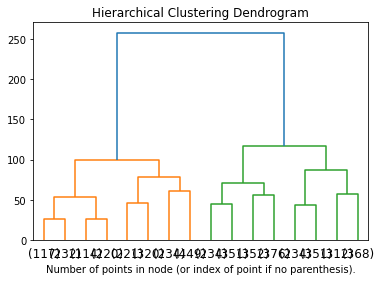

The adjusted Rand index has a value of 0.1395
The Normalized Mutual Information has a value of 0.4789


In [48]:
from scipy.cluster.hierarchy import dendrogram

model = AgglomerativeClustering(linkage='ward', distance_threshold=12, n_clusters=None)
y_pred = model.fit_predict(X)

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

plt.title("Hierarchical Clustering Dendrogram")
# Plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

# Calculate some metrics
print('The adjusted Rand index has a value of {0:.4f}'.format(adjusted_rand_score(np.array(y.position), y_pred)))
print('The Normalized Mutual Information has a value of {0:.4f}'.format(normalized_mutual_info_score(np.array(y.position), y_pred)))

### Hierarchical Clustering: DBSCAN

In [49]:
# Create the model
model = DBSCAN(eps=0.5, min_samples=5)

# Fit model and make predictions
y_pred = model.fit_predict(X)

# Calculate some metrics
print('The adjusted Rand index has a value of {0:.4f}'.format(adjusted_rand_score(np.array(y.position), y_pred)))
print('The Normalized Mutual Information has a value of {0:.4f}'.format(normalized_mutual_info_score(np.array(y.position), y_pred)))

The adjusted Rand index has a value of 0.1332
The Normalized Mutual Information has a value of 0.5275


### Gaussian Mixture Model

In [50]:
# Create the model
model = GaussianMixture(n_components=12)

# Fit the model and make predictions
y_pred = model.fit_predict(X)

# Calculate some metrics
print('The adjusted Rand index has a value of {0:.4f}'.format(adjusted_rand_score(np.array(y.position), y_pred)))
print('The Normalized Mutual Information has a value of {0:.4f}'.format(normalized_mutual_info_score(np.array(y.position), y_pred)))

The adjusted Rand index has a value of 0.2607
The Normalized Mutual Information has a value of 0.5230


## Positions grouping

In this section we are grouping the positions in 4 master categories, corresponding to supine, prone, left and right positions. \
We are aiming to train a classifier able to classify perfectly the data in 4 categories.

In [51]:
grouped_dataset = dataset_avg_min_max.copy()

grouped_dataset.loc[grouped_dataset.position == 2, 'position'] = 1
grouped_dataset.loc[grouped_dataset.position == 3, 'position'] = 1
grouped_dataset.loc[grouped_dataset.position == 4, 'position'] = 2
grouped_dataset.loc[grouped_dataset.position == 5, 'position'] = 2
grouped_dataset.loc[grouped_dataset.position == 6, 'position'] = 2
grouped_dataset.loc[grouped_dataset.position == 7, 'position'] = 3
grouped_dataset.loc[grouped_dataset.position == 8, 'position'] = 3
grouped_dataset.loc[grouped_dataset.position == 9, 'position'] = 3
grouped_dataset.loc[grouped_dataset.position == 10, 'position'] = 4
grouped_dataset.loc[grouped_dataset.position == 11, 'position'] = 4
grouped_dataset.loc[grouped_dataset.position == 12, 'position'] = 4

In [52]:
grouped_dataset.head()

,subject_id,sex,x_chest_avg,x_chest_min,x_chest_max,y_chest_avg,y_chest_min,y_chest_max,z_chest_avg,z_chest_min,...,x_ankle_avg,x_ankle_min,x_ankle_max,y_ankle_avg,y_ankle_min,y_ankle_max,z_ankle_avg,z_ankle_min,z_ankle_max,position
0,1,F,-6.333333,-9,-5,92.296296,88,99,-237.370370,-239,...,-245.962963,-246,-245,37.925926,37,38,28.925926,28,29,1
1,1,F,2.230769,1,4,93.615385,91,96,-236.897436,-238,...,-235.871795,-244,-229,38.000000,37,39,80.307692,43,103,1
2,1,F,-6.230769,-8,-4,85.461538,83,88,-240.769231,-241,...,-218.076923,-224,-216,37.000000,36,38,126.230769,114,130,1
3,1,F,0.769231,0,1,-206.487179,-208,-204,148.564103,146,...,245.282051,245,246,-17.000000,-17,-17,-26.051282,-27,-25,2
4,1,F,3.871795,3,5,-180.461538,-182,-178,182.538462,182,...,202.256410,202,203,-26.948718,-27,-26,-138.256410,-139,-137,2


In [53]:
# Train-test split

gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=123)
gss.get_n_splits()

X = grouped_dataset.drop(['sex', 'position'], axis=1)
position = grouped_dataset['position']
subject_id = grouped_dataset['subject_id']
columns = list(grouped_dataset.columns)
columns.remove('sex')
columns.remove('position')

# Split with respect to subject_id to prevent a subject from being in both train and test sets
for train_idx, test_idx in gss.split(X, position, subject_id):
    X_train_grp = np.array(X)[train_idx]
    y_train_grp = np.array(position)[train_idx]
    X_test_grp = np.array(X)[test_idx]
    y_test_grp = np.array(position)[test_idx]

X_train_grp = pd.DataFrame(X_train_grp, columns=columns)
y_train_grp = pd.DataFrame(y_train_grp, columns=['position'])
X_test_grp = pd.DataFrame(X_test_grp, columns=columns)
y_test_grp = pd.DataFrame(y_test_grp, columns=['position'])

print(X_train_grp['subject_id'].value_counts(), X_test_grp['subject_id'].value_counts())

# Concatenate X and y to shuffle the data
df_train_grp = pd.concat([X_train_grp, y_train_grp], axis = 1)
df_train_grp = df_train_grp.sample(frac=1)
df_test_grp = pd.concat([X_test_grp, y_test_grp], axis = 1)
df_test_grp = df_test_grp.sample(frac=1)

# Shuffle the data
X_train_grp = df_train_grp.drop(['position'], axis=1)
y_train_grp = df_train_grp[['position']]
X_test_grp = df_test_grp.drop(['position'], axis=1)
y_test_grp = df_test_grp['position']

2.0     12
3.0     12
4.0     12
6.0     12
10.0    12
11.0    12
7.0     10
Name: subject_id, dtype: int64 1.0    12
5.0    12
8.0    12
Name: subject_id, dtype: int64


In [54]:
# Learn scaler on train set
scaler = StandardScaler().fit(X_train_grp.iloc[:,1:])

# Standardize train set
X_train_grp.iloc[:,1:] = scaler.transform(X_train_grp.iloc[:,1:])

# Standardize test set
X_test_grp.iloc[:,1:] = scaler.transform(X_test_grp.iloc[:,1:])

In [55]:
def hyperp_search_grp(classifier, parameters, k, X_train, y_train, X_test, y_test):
    ''' This function takes as input a classifier (e.g. Decision Tree), a dictionary of parameters, the number of folds k for the cross-valdiation,
                                     the train (X_train, y_train) and the test (X_test, y_test) sets
                      performs a grid search using the cross-validation method and stores the best set of parameters looking at the performances on the validation sets
                      prints the different metrics on the train and the test sets
                      returns the best model fitted (refit=True) on the best set of parameters found
    '''

    # Hyperparameter tuning via cross-validation
    gs = GridSearchCV(classifier, parameters, cv=k, scoring = 'accuracy', refit=True, verbose=0, n_jobs=-1) # refit=True refits the model with the best found parameters on the whole dataset
    gs = gs.fit(X_train, y_train)

    # Prediction on train and test sets with best model found
    best_model = gs.best_estimator_
    y_test_pred = best_model.predict(X_test)
    y_train_pred = best_model.predict(X_train)

    # Results display
    print("\n \033[1m ***Best result obtained*** \033[0m \n")
    print("accuracy (mean cross-validated score): %f using %s" % (gs.best_score_, gs.best_params_))

    print("\n \033[1m ***Scores obtained on train and test sets with best model*** \033[0m \n")
    print("f1          train %.3f   test %.3f" % (f1_score(y_train, y_train_pred, average='macro'), f1_score(y_test, y_test_pred, average='macro'))) 
    print("recall      train %.3f   test %.3f" % (recall_score(y_train, y_train_pred, average='macro'), recall_score(y_test, y_test_pred, average='macro'))) 
    print("precision   train %.3f   test %.3f" % (precision_score(y_train, y_train_pred, average='macro'), precision_score(y_test, y_test_pred, average='macro'))) 
    print("accuracy    train %.3f   test %.3f" % (accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred))) 

    print("\n \033[1m ***Classification report on test set*** \033[0m \n")
    print(classification_report(y_test, y_test_pred, target_names=['1', '2', '3', '4']))

    print("\n \033[1m ***Confusion matrix on test set*** \033[0m \n")
    plot_confusion_matrix(best_model, X_test, y_test, display_labels=['1', '2', '3', '4'], values_format='', cmap='Reds')

    return best_model

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



  ***Best result obtained***  

accuracy (mean cross-validated score): 0.975000 using {'n_neighbors': 3}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.976   test 1.000
recall      train 0.975   test 1.000
precision   train 0.977   test 1.000
accuracy    train 0.976   test 1.000

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


  ***Confusion matrix on test set***  



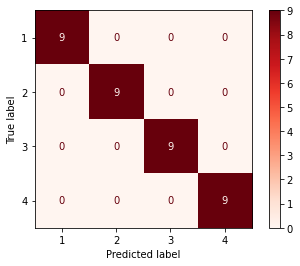

In [56]:
classifier = KNeighborsClassifier()
parameters = {'n_neighbors':np.arange(3,50,1)}

best_model_knn_grp = hyperp_search_grp(classifier, parameters, 5, X_train_grp, y_train_grp, X_test_grp, y_test_grp)


  ***Best result obtained***  

accuracy (mean cross-validated score): 0.975735 using {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 3}

  ***Scores obtained on train and test sets with best model***  

f1          train 1.000   test 1.000
recall      train 1.000   test 1.000
precision   train 1.000   test 1.000
accuracy    train 1.000   test 1.000

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


  ***Confusion matrix on test set***  



C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


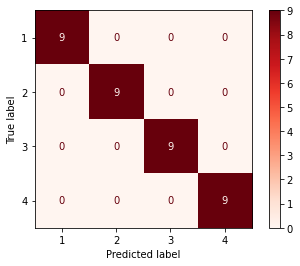

In [57]:
classifier = DecisionTreeClassifier()
parameters = {'criterion': ['entropy','gini'], 
              'max_depth': [4, 5, 6],
              'min_samples_split': [3, 5],
              'min_samples_leaf': [3, 5]}

best_model_tree_grp = hyperp_search_grp(classifier, parameters, 5, X_train_grp, y_train_grp, X_test_grp, y_test_grp)

C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\patri\anaconda3\envs\pcb\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



  ***Best result obtained***  

accuracy (mean cross-validated score): 0.975000 using {'C': 0.01, 'kernel': 'linear'}

  ***Scores obtained on train and test sets with best model***  

f1          train 0.975   test 1.000
recall      train 0.975   test 1.000
precision   train 0.975   test 1.000
accuracy    train 0.976   test 1.000

  ***Classification report on test set***  

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


  ***Confusion matrix on test set***  



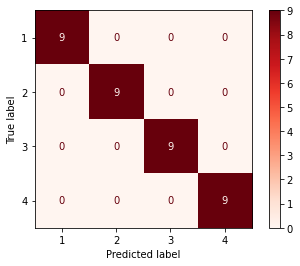

In [58]:
classifier = SVC()
parameters = {"kernel":['linear'],
              "C":[0.01,0.1]}

best_model_svm_grp = hyperp_search_grp(classifier, parameters, 5, X_train_grp, y_train_grp, X_test_grp, y_test_grp)

Using the best found models, we are able to perfectly predict the 4 master positions of the test set.

## Performance analysis -- **TO COMPLETE**

In [59]:
from yellowbrick.classifier import ClassPredictionError

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(RandomForestClassifier(criterion='gini', max_depth=5, min_samples_leaf=3, min_samples_split=3, n_estimators=10, random_state=42))

# Fit the training data to the visualizer
visualizer.fit(X_train_avg_min_max, y_train_avg_min_max)

# Evaluate the model on the test data
visualizer.score(X_test_avg_min_max, y_test_avg_min_max)

# Draw visualization
visualizer.show()

ModuleNotFoundError: No module named 'yellowbrick'